<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Experiments and Hypothesis Testing


<a id="learning-objectives"></a>
### Learning Objectives
- Explain the difference between causation and correlation.
- Determine causality and sampling bias using directed acyclic graphs.
- Identify what missing data is and how to handle it.
- Test a hypothesis using a sample case study.

Today, we’ll use advertising data from an example in the book [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).
- This is a well-known, standard introduction to machine learning.
- The book has a more advanced version — [Elements of Statistical Learning](http://web.stanford.edu/~hastie/ElemStatLearn/) — if you are comfortable with linear algebra and statistics at the graduate level.

## 1. Thinking about data in terms of independent and dependent variables

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# This allows plots to appear directly in the notebook.
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Read data into a DataFrame.
# We use index_col to tell Pandas that the first column in the data has row labels.
advertising_data = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv', index_col=0)
advertising_data.columns = ['tv_spend','radio_spend','newspaper_spend','sales']
advertising_data.head()

,tv_spend,radio_spend,newspaper_spend,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


This data shows advertising spend (in dollars) spent on TV, radio and newspaper advertising for a single product and corresponding sales of that product in thousands of dollars.

Each row corresponds to a single market (or geography) in which the product was advertised. 

Let's consider the question **on the basis of this data, how should the manufacturer spend its advertising money in future?**

Let's start by identifying the dependent and independent variables.

The **independent** variable is the outcome, or response, or target of our model.

The **dependent** variables, sometimes known as features, covariates, or predictors, are the inputs to our model.

In predictive modelling tasks, the dependent variables are used to predict the independent variables.

## Exercise

What are the features/covariates/independent variables/predictors in this case?

What's the dependent variable/outcome/response?

What are the possible values the covariance could have?


In [3]:
# Independent variable/Target: sales
# Dependent variables/Features: tv_spend, radio_spend, newspaper_spend
# Covariance could be positive, i.e. when expenditure increases, sales increases or negative, i.e. when expenditure increases, sales decreases


## 2. Covariance and correlation 


<a id="covariance"></a>
### Covariance

Covariance is a measure of the joint variability between two random variables.

You can think of this as a measure of linear association. If you have a variance of Y and a variance of X, the covariance is the amount of variance they share.

$$cov(X, Y) = \frac {\sum{(x_i - \bar{X})(y_i - \bar{Y})}} {n}$$

We can gain insight into covariance by looking closely at the formula above. First, observe that the formula effectively pairs the first $x$ data point with the first $y$ data point: $(x_1, y_1)$. All computations are done solely on these pairs of points.

Second, let's ask ourselves, **when would covariance be positive**? 

From the numerator, covariance would be positive if, for all pairs of data points, $(x_i - \bar{X})$ and $(y_i - \bar{Y})$ are 1) both positive or 2) both negative. 

This occurs when: 1) Both data points are greather than their respective means. 

Or when: 2) Both data points are less than their respective means! 

So, if the $x$ data points vary from their mean in the same way the $y$ data points vary from their mean, covariance will be positive.

Third, let's consider: **Might outliers affect covariance?** 

Yes! Given the structure of the formula (a sum of terms), a large outlier pair far from the means could strongly pull the covariance in one direction.

**A Useful Special Case**

The covariance between one variable and itself is just its variance 

$$cov(X, X) = \frac {\sum{(x_i - \bar{X})^2}} {n} = var(X) = \sigma_X^2$$

In [4]:
first_five = advertising_data.loc[0:5,:]
first_five

,tv_spend,radio_spend,newspaper_spend,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


(a) Compute the mean sales, $\bar{Y}$, across the first five rows

In [5]:
y_mean = first_five['sales'].mean()
y_mean

14.64

(c) Compute the mean TV spend, $\bar{X}$, across the first five rows

In [6]:
x_mean = first_five['tv_spend'].mean()
x_mean

124.82000000000001

(d) Compute $\sum{(x_i - \bar{X})(y_i - \bar{Y})}$

In [7]:
#Each row of x column minus the mean
x_x_mean = first_five['tv_spend']-x_mean
#Each row of y column minus the mean
y_y_mean = first_five['sales']-y_mean

In [24]:
first_five['tv_spend']-x_mean
#type(x_x_mean)

1    105.28
2    -80.32
3   -107.62
4     26.68
5     55.98
Name: tv_spend, dtype: float64

In [9]:
# Dot product of two arrays
y_y_mean.dot(x_x_mean)

1706.216

(e) What's $n$ for this dataset?

In [10]:
#Number of values in the column (must be same for both x and y!)
n=5

(f) Use the calculations above to get the covariance between TV advertising spend, and sales. 

In [12]:
cov_x_y = y_y_mean.dot(x_x_mean)/n
cov_x_y

341.2432

<a id="correlation"></a>
### Correlation

While covariance is a useful measure, it can be difficult to compare covariances, as they are not standardized. 

Instead we can use the correlation, which measures the same effect but reports it as a range from -1 to 1. 1 represents perfect covariance and correlation, 0 represents no correlation, and -1 one represents perfect inverse correlation.

$$corr(X,Y) = \frac {cov(X,Y)} {\sigma_X\sigma_Y}$$

Note that the variance is always positive, making the denominator positive. So, the sign of the covariance between $X$ and $Y$ is the same as the sign of their correlation! 

The following visual examples better illustrate how correlation refers to how $X$ and $Y$ change together. Notice that a correlation number by itself is not always indicative of the relationship between the variables — always try to supplement 2-D correlation with a visual!

![](./assets/images/correlation_examples.png)

In [51]:
#Calculate the denominator in correlation equation (tv_spend is X and sales is Y)
x_std = advertising_data['tv_spend'].std()
y_std = advertising_data['sales'].std()
corr_denominator = x_std * y_std
corr_denominator

447.94074895527615

<a id="the-variance-covariance-matrix"></a>
### The Variance-Covariance Matrix

For our purposes in modeling and machine learning, the fastest way to get a preview of the underlying relationships in our data is to use the variance-covariance matrix.

The variance-covariance matrix shows the covariance between every variable in our data set.

Given $n$ features from $X_1$ to $X_n$, the variance-covariance matrix looks like this (recall that $cov(X, X) = var(X)$):

$$\left[ \begin{array}{c}
var(X_1) & cov(X_1,X_2) & ... & cov(X_1,X_n)  \\
cov(X_2,X_1) & var(X_2) & ... & cov(X_2,X_n)  \\
... & ... & ... & ... \\
cov(X_n,X_1) & cov(X_n,X_2) & ... & var(X_n)
\end{array} \right]$$

From a quick glance at this matrix, we can glean insight about which variables might be strongly correlated. This may also indicate redundant features and/or affect some models.

If data are centered around the mean, every column has its mean subtracted from itself. So, the mean for every column is now 0. You can then compute the variance-covariance matrix as:

$$\frac {X^TX} {n}$$

Those of you who have been exposed to linear regression may recognize this term.

To get from the variance-covariance matrix to the correlation matrix, we divide each element by the products of the corresponding standard deviations.

$$\left[ \begin{array}{c}
var(X_1)/\sigma(X_1)^2 & cov(X_1,X_2)/\sigma(X_1)\sigma(X_2) & ... & cov(X_1,X_n)/\sigma(X_1)\sigma(X_n)  \\
cov(X_2,X_1)/\sigma(X_2)\sigma(X_1) & var(X_2)/\sigma(X_2)^2 & ... & cov(X_2,X_n)\sigma(X_2)\sigma(X_n)  \\
... & ... & ... & ... \\
cov(X_n,X_1)/\sigma(X_n)\sigma(X_1) & cov(X_n,X_2)/\sigma(X_n)\sigma(X_2) & ... & var(X_n)/\sigma(X_n)^2
\end{array} \right]$$

## Exercise

(a) Use the answer to the last exercise to find the correlation coefficient between TV spend and sales

In [52]:
# THIS IS WRONG!!! TO RERUN
corr_x_y = cov_x_y / corr_denominator
corr_x_y

0.761804325228002

In [53]:
# Use Pandas function corr() to calculate correlation coefficient of TV spend and sales
x = advertising_data['tv_spend']
y = advertising_data['sales']
y.corr(x)

0.7822244248616061

In [54]:
# Use NumPy function corrcoef() to calculate correlation matrix of TV spend and sales
np.corrcoef(x, y)

array([[1.        , 0.78222442],
       [0.78222442, 1.        ]])

(b) Calculate the correlation matrix between all pairs of variables in the advertising dataset, using the DataFrame's built-in `.corr()` method:

In [30]:
# We use Pandas function corr() to calculate correlation matrix for whole DataFrame
advertising_data.corr()

,tv_spend,radio_spend,newspaper_spend,sales
tv_spend,1.000000,0.054809,0.056648,0.782224
radio_spend,0.054809,1.000000,0.354104,0.576223
newspaper_spend,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


In [35]:
# Calculate covariance matrix  for whole DataFrame by hand (same results as below)
X = advertising_data - advertising_data.mean() 
X.T.dot(X) / (len(advertising_data)-1)

,tv_spend,radio_spend,newspaper_spend,sales
tv_spend,7370.949893,69.862492,105.919452,350.390195
radio_spend,69.862492,220.427743,114.496979,44.635688
newspaper_spend,105.919452,114.496979,474.308326,25.941392
sales,350.390195,44.635688,25.941392,27.221853


In [31]:
# Calculate covariance matrix for whole DataFrame using cov() function 
advertising_data.cov()

,tv_spend,radio_spend,newspaper_spend,sales
tv_spend,7370.949893,69.862492,105.919452,350.390195
radio_spend,69.862492,220.427743,114.496979,44.635688
newspaper_spend,105.919452,114.496979,474.308326,25.941392
sales,350.390195,44.635688,25.941392,27.221853


When we have a large amount of data, the correlation matrix may be too difficult to read. It can help to make a plot.

(c) Use Seaborn's `.heatmap()` function to make a plot of the correlation matrix. Remember that we imported Seaborn as `sns`.


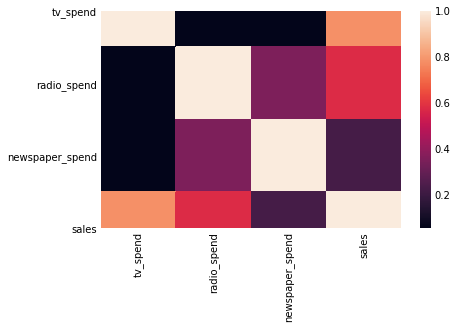

In [32]:
# Make a heatmap on the correlation matrix
advertising_correlations = advertising_data.corr();
sns.heatmap(advertising_correlations);

Of course, looking at linear association doesn't show us the whole picture. We can get a more detailed look with a scatterplot matrix.

(d) Use Seaborn's `.pairplot()` function to make joint scatterplots of the data. What do these plots show? What do they tell us about our data? 

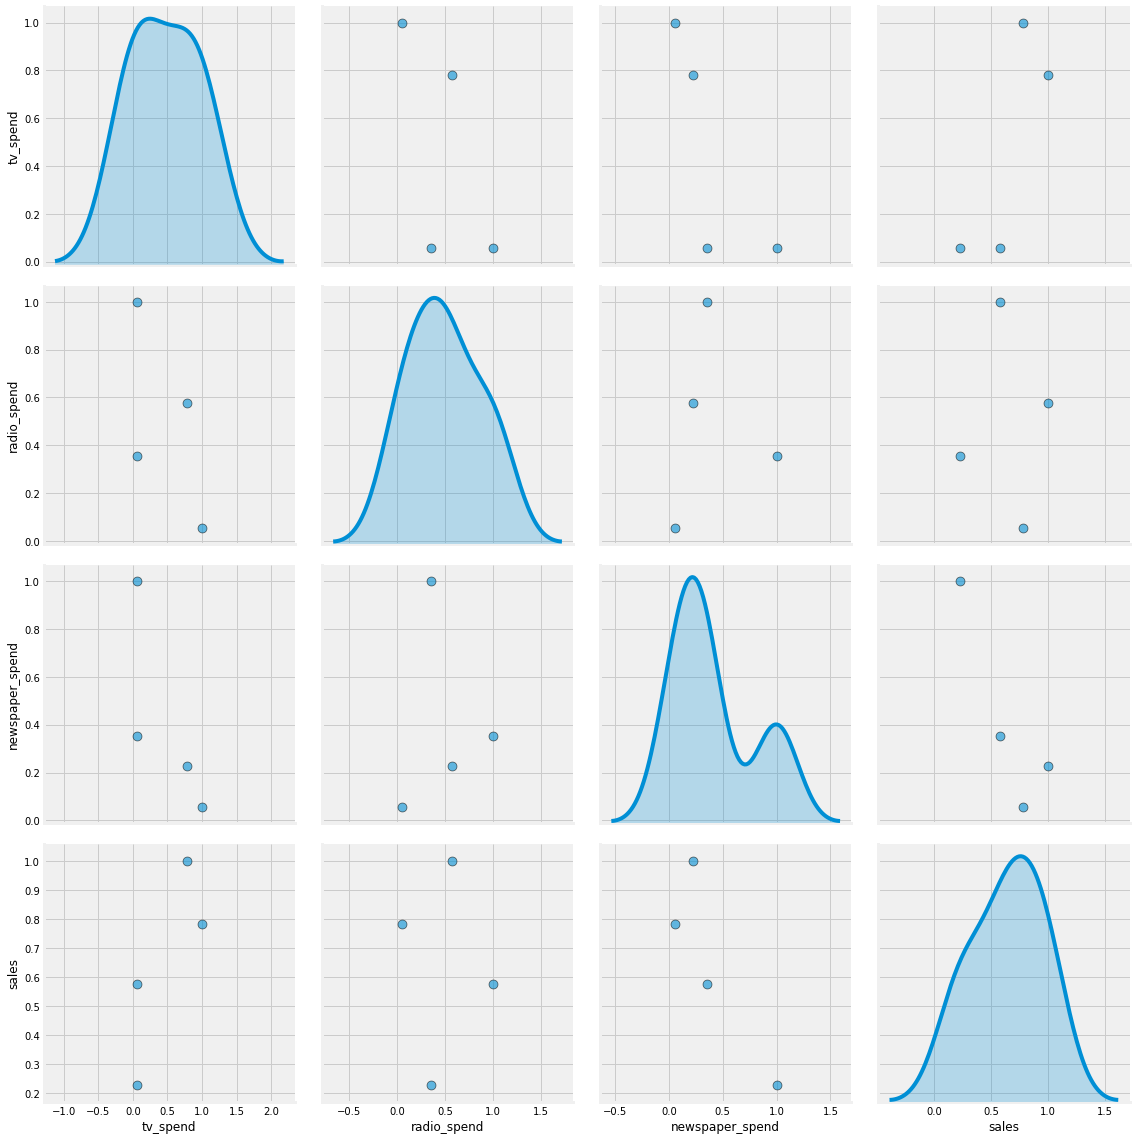

In [21]:
sns.pairplot(advertising_correlations, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height=4);

<a id="causation-and-correlation"></a>
## 3. Causation and Correlation

Take a look at some of these examples of [Spurious Correlations](http://www.tylervigen.com/spurious-correlations).

The variables are **correlated** but may or may not be **causal**.

Understanding this difference is critical for executing the data science workflow, especially when identifying and acquiring data.

Be careful not to say “caused” when you really mean “is associated with.”

<a id="how-do-we-determine-if-something-is-causal"></a>
### How Do We Determine if a Relationship is Causal?

One attempt that's commonly used in the medical field is based on work by Bradford Hill. He developed a list of “tests” that an analysis must pass in order to indicate a causal relationship:

**Strength of association (effect size)**: A small association does not mean that there is not a causal effect, although the larger the association, the more likely the effect is to be causal.

**Consistency (reproducibility)**: Consistent findings observed by different persons in different places with different samples strengthens the likelihood of an effect.

**Specificity**: Causation is likely if there is a very specific population at a specific site and a disease with no other likely explanation. The more specific an association between a factor and an effect, the greater the probability of a causal relationship.

**Temporality**: The effect has to occur after the cause (and, if there is an expected delay between the cause and expected effect, then the effect must occur after that delay).

**Biological gradient**: Greater exposure should generally lead to greater incidence of the effect. However, in some cases, the mere presence of the factor can trigger the effect. In other cases, an inverse proportion is observed: greater exposure leads to lower incidence.

**Plausibility**: A plausible mechanism between cause and effect is helpful (but Hill noted that knowledge of the mechanism is limited by current knowledge).

**Coherence**: Coherence between epidemiological and laboratory findings increases the likelihood of an effect. However, Hill noted that "... lack of such [laboratory] evidence cannot nullify the epidemiological effect on associations."

**Experiment**: "Occasionally it is possible to appeal to experimental evidence."

**Analogy**: The effect of similar factors may be considered.

<a id="pearlean-causal-dag-model"></a>
### The Pearlean Causal Directed Acyclic Graph (DAG) Model

This model is a visual tool to help us reason about causality and association. It was proposed by Judea Pearl, although there are many similar models. We will only scratch the surface, so look into other resources if you're interested in learning more. We'll cover the basic idea and most notable cases.

<a id="what-is-a-dag"></a>
### What Is a DAG?

DAG stands for directed acyclic graph. 

It's a collection of nodes connected by lines; in maths we call this a **graph**

Each line has an arrow to point in a direction, so it's **directed**

If you follow the arrows, you reach a final node. There are no loops, so it's **acyclic**

A single circle or node in a causal DAG represents an event; something that happens at one point in time.

![](./assets/images/dag1.png)

Let's say two random variables X and Y — or two different types of events — are correlated with each other.

**What are the possible causal structures that would produce this correlation?**

<a id="its-possible-that-x-causes-y"></a>
### X causes Y
![](./assets/images/x-cause-y.png)

<a id="y-causes-x"></a>
### Y causes X.
![](./assets/images/y-cause-x.png)

<a id="the-correlation-between-x-and-y-is-not-statistically-significant"></a>
### The correlation between X and Y is not statistically significant.
![](./assets/images/xy.png)

<a id="x-or-y-may-cause-one-or-the-other-indirectly-through-another-variable"></a>
### X or Y may cause one or the other indirectly through another variable.
![](./assets/images/x-c-z-y.png)

<a id="there-is-a-third-common-factor-that-causes-both-x-and-y"></a>
### There is a third common factor that causes both X and Y.
![](./assets/images/z-cause-xy.png)

This is an example of a **confounder**. Let’s say we performed an analysis to understand what causes lung cancer. 

We find that people who carry cigarette lighters are 2.4 times more likely to contract lung cancer than people who don’t carry lighters.

Does this mean that the lighters are causing cancer?

As we've noted before, if lighters and cancer are both caused by smoking, there will be a correlation between lighters and cancer. This isn't the only possible diagram, but it makes the most sense.
![](./assets/images/smoke-lighter-cancer.png)

If we believe the structure above, conditioning on smoking by only looking at non-smokers removes the correlation between lighters and cancer.

<a id="both-x-and-y-cause-a-third-variable-and-the-dataset-does-not-represent-that-third-variable-evenly"></a>
### X and Y cause a third factor, but our data collect the third factor unevenly.

![](./assets/images/xy-causez.png)

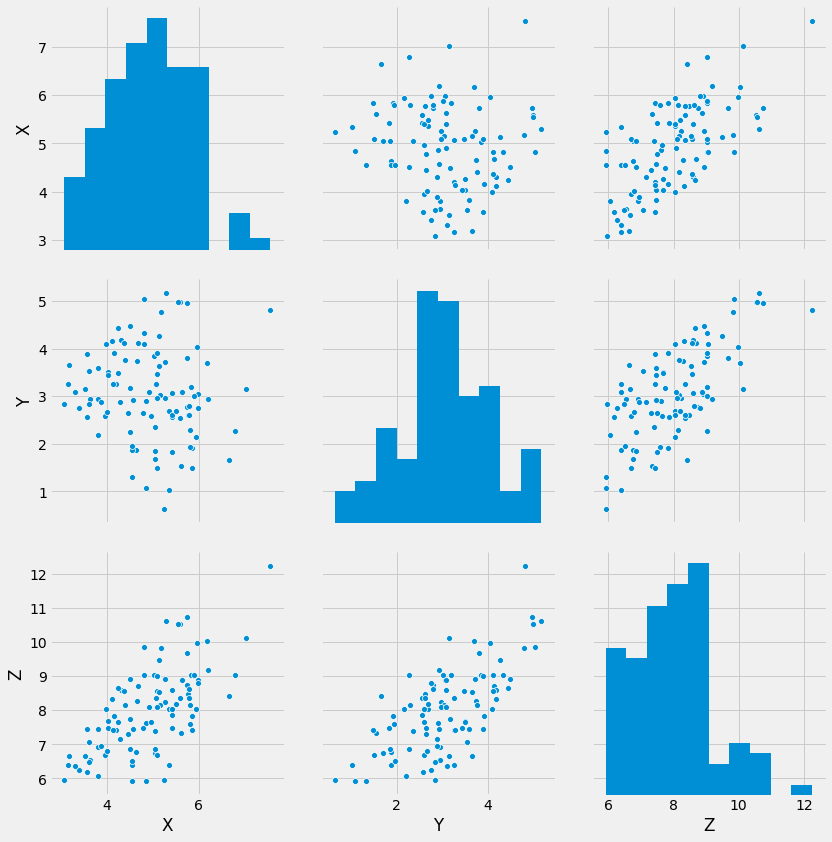

In [58]:
#np.random.randn function returns sample for "normal distribution" of 100 data points
# Z is a function of X and Y:
X = 5 + np.random.randn(100)
Y = 3 + np.random.randn(100)
Z = X + Y + 0.1*np.random.randn(100)
common_effect = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})

# Make a pairplot of the data:
sns.pairplot(common_effect, height=4);

Generally, recovering the causality structure from a correlation matrix is difficult or at times impossible. However, thinking through causal effects can give you a much better intuition regarding your variables and your data.

<a id="controlled-experiments"></a>
### Controlled Experiments

- The most foolproof way to measure an effect is to control all of the confounders and directly intervene and control our variable of interest. 
- This way we know that any correlation we find is not because of the confounders but instead because of the variable we control. 
- This also means that all the effects we see are due to the variable we control.
- However, experiments are not always possible and take longer than using observational data.


## Exercise: Explore the Associations in the Advertising Data

#### Visualize the relationship between the features and the response using scatterplots.

- Below, we filled in how to make a scatterplot for the columns `sales` vs `TV`. 
- Using this as an example, can you also make scatterplots for `sales` vs `radio` and `sales` vs `newspaper`?
- `axs[0]` is the first coordinate grid, `axs[1]` is the second coordinate grid, etc.

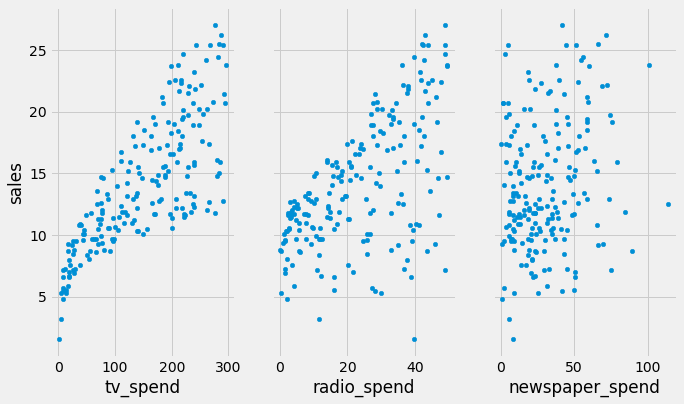

In [63]:
# Visualize the relationship between the features and the response using scatterplots:
fig, axs = plt.subplots(1, 3, sharey=True)

advertising_data.plot(kind='scatter', x='tv_spend', y='sales', ax=axs[0], figsize=(10, 6));
advertising_data.plot(kind='scatter', x='radio_spend', y='sales', ax=axs[1], figsize=(10, 6));
advertising_data.plot(kind='scatter', x='newspaper_spend', y='sales', ax=axs[2], figsize=(10, 6));

#### Is there a relationship between ads and sales? Which type of ads?

#### Can we say this a causal relationship?

#### What other questions might we want to know about this data?

### Section Summary

1) **It's importlant to have deep subject area knowledge.** You'll develop this over time and it will help you move through your analysis in a logical manner. However, keep in mind that you can show a strong association and still be wrong.

2) **A DAG (directed acyclic graph) can be a handy tool for thinking through the logic of your models.**

3) **There is a distinction between causation and correlation.** In our smoking example, it's relatively obvious that there's a flaw in our logic; however, this won't always be so readily apparent — especially in cutting-edge fields where there are many other unknown variables.

4) **Good data are essential.** Throughout this course we will be developing your data intuition so you can spot gaps and bias more readily. You'll also be introduced to tools that can help. However, your analysis is only as good as your understanding of the problem and the data.

<a id="sampling-bias"></a>
## 4. Sampling Bias

**Sampling bias** occurs when a sample is collected in such a way that some members of the intended population are more or less likely to be included than others.

This can happen when a sample is taken non-randomly — either implicitly or explicitly.

When we have non-random sampling that results in sampling bias, it can affect the inferences or results of our analyses. We must be sure not to attribute our results to the process we observe when they could actually be because of non-random sampling.

Conceptually, this is straightforward: When we have sampling bias, we aren't measuring what we think we are measuring.

<a id="forms-of-sampling-bias"></a>
### Examples of Sampling Bias

- **Pre-screening:** Purposely restricting the sample to a specific group or region.
    - This typically happens when people try to study priority areas to save costs and assume priority areas are the same as random areas.
- **Self-selection:** When someone has the ability to non-randomly decide what is included in a sample.
    - This typically happens in surveys and polls but can also be an issue with other kinds of reporting.
- **Survivorship bias:** When we select only surviving subjects in a sample over time.
    - This might happen when we only look at existing customers and assume they have the same characteristics as new customers.
    
<a id="problems-from-sampling-bias"></a>
### Problems That Arise From Sampling Bias
- We could overestimate or underestimate means and sample statistics for simple characteristics.
- It's possible to have artificial correlation where there should be none.

<a id="stratified-random-sampling"></a>
### Stratified Random Sampling

We've discussed how it is important to obtain a random sample of our population. However, sometimes it is more effective to apply some reasoning to our sampling process. By optimizing how we choose samples, we can possibly create a more accurate model using fewer samples.

**Stratified random sampling** ensures we capture important population characteristics in the random sample. If we know that the population is half males and half females, for example, we can make sure that our sample is half male and half female. 

We effectively break the population into two "strata" (groups), then randomly sample from each group to obtain our overall sample. This method is similar to taking a weighted average and depends on knowing key population statistics.

For example, if we are collecting survey data, we might ensure our participants are evenly split between men and women.


<a id="missing-data"></a>
## 5. Missing Data

Sometimes we are unable to collect every attribute for a particular observation.

Unfortunately, this makes the observation unusable until we decide how to deal with it.

**We have to decide whether to:**

* Drop the observation.
* Drop the attribute.
* Impute a value for that specific attribute and observation.

**So, how do we decide?**

<a id="types-of-missing-data"></a>
### Types of Missing Data

#### Missing completely at random (MCAR)
The reason that the data are missing is completely random and introduces no sampling bias.

In this case, it's safe to drop or impute.

We can test for this by looking at other attributes for missing and non-missing groups to see if they match.

#### Missing at random (MAR)
The data are missing in a way that is related to another factor.

This is a form of sampling bias.

Like other instances of sampling bias, we can fix this by modeling the selection process.

This is done by building a model to impute the missing value based on other variables.

#### Missing not at random (MNAR)
The response, or dependent variable, is missing in a way that relates to its own value.

We can't test for this.

We also can't fix this in a reasonable way.

## Exercise

Take a look at the results of this survey, where IQ scores for people of different ages have been collected. The complete dataset is shown, together with three examples where data is missing.

Is the data in each of the three incomplete datasets MCAR, MAR or MNAR? How did you work this out?

<img src='./assets/images/complete_data.png' width="200"> 
<img src='./assets/images/mnar_data.png' width="200">
<img src='./assets/images/mar_data.png' width="200">
<img src='./assets/images/mcar_data.png' width="200">


<a id="class-imbalance"></a>
### Class Imbalance

Sometimes a sample may include an overrepresentation of one type of class. For example, airport security may have 990 X-ray scans showing the absence of a weapon. Due to natural scarcity, it may only provide 10 scans showing a weapon.

If our goal is to create a model that indicates whether or not a weapon is present, then we are at a disadvantage. **Ignoring the class imbalance** would lead to a model that always guesses that a weapon is not present!
 
Note that most optimization procedures optimize for training data accuracy. Always guessing that a weapon is absent leads to 990/1000 correct results; an accuracy of 99 percent.

A simple way to get around this is to **undersample** the majority class, deliberately leaving us with a balanced data set of 10 each. However, this is less than ideal, as it effectively ignores much of the available data.

Alternatively, we could **oversample** the minority class by duplicating examples. Again, this is not ideal. Because we have very little data, this will magnify small differences that may just be errors, leading to a model that overfits.

Later in the course, we will look at additional methods for training models to work around class imbalance. For example, we may use an optimization algorithm that cares less about accuracy and more about minimizing particular types of errors.

<a id="error-types"></a>
## 6. Error Types

Statisticians often classify errors not just as errors but as one of two specific types of errors — type I and type II.

+ **Type I errors** are false positives.
    - Machine learning: Our model falsely predicts "positive." (The prediction is incorrect.)
    - Statistics: Incorrect rejection of a true null hypothesis.


+ **Type II errors** are false negatives.
    - Machine learning: Our model falsely predicts "negative." (The prediction is incorrect.)
    - Statistics: Incorrectly retaining a false null hypothesis.
    
  
## Exercise

For the following scenarios, discuss on your tables what a Type I and Type II error would correspond to in real life. Which type of error is preferable in each scenario?

(a) A blood test, where a positive result indicates the presence of a deadly and fast acting disease.

(b) A judge, where a positive result means a defendent will be sentenced to life in prison without possibility of parole.



  

<img src='./assets/images/errors.png' width="800"> 
Understanding these errors can be especially beneficial when designing models. For example, we might decide that type I errors are OK but type II errors are not. We can then optimize our model appropriately.
